In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [6]:
##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Yearly data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

##Bands and indices

df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4'])) ##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])

##IMPORTANT: again, these bands between landsat 5 and 8 may not be able to be compared directly

##Variables from Byrd et al. 2018 (make sure calculations are accurate):
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

##DAYMET data added - yearly averages
##PC:
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)

dm['ident'] = dm['Latitude']/dm['Longitude']

display(dm)


##Seasonal averages: growing season (defined as between 3/1 and 10/31)
path3 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Growing season' 
all_files3 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files3:
    dm2 = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm2)

dm2 = pd.concat(li, axis=0, ignore_index=True)

dm2['ident'] = dm2['Latitude']/dm2['Longitude']

dm2 = dm2.rename(columns={'dayl': 'sn_dayl', 'prcp': 'sn_prcp', 'srad': 'sn_srad', \
                        'tmax': 'sn_tmax','tmin': 'sn_tmin','vp': 'sn_vp'})

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df)

,dayl,prcp,srad,swe,tmax,tmin,vp,system:index,Site,Species_Code,Year,Quadrat_Area,Zone,Plot,Latitude,Plant_Biomass,Sample_Size,Longitude,Date,ident
0,43200.085938,2.568438,342.593597,0.0,25.048056,14.132274,1776.901489,0,1,A1,2000,0.25,1,1,31.538627,516.324,23,-81.422539,10/11/2000,-0.387345
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,A1,2000,0.25,1,1,31.536199,1152.400,21,-81.296118,10/11/2000,-0.387918
2,43200.085938,2.319699,336.004730,0.0,24.539864,15.079507,1874.970703,2,3,A1,2000,0.25,1,1,31.518920,710.396,20,-81.228956,10/18/2000,-0.388026
3,43200.085938,2.472329,340.215027,0.0,24.868795,14.635425,1827.156250,3,4,A1,2000,0.25,1,1,31.451676,1534.304,25,-81.365498,10/10/2000,-0.386548
4,43200.085938,2.445726,340.010864,0.0,24.818274,14.757424,1839.845947,4,5,A1,2000,0.25,1,1,31.436090,2022.264,25,-81.339919,10/10/2000,-0.386478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,43219.992188,3.616016,331.420837,0.0,26.539396,16.000111,1951.389526,172,4,A1,2019,0.25,1,56,31.451282,820.556,12,-81.366151,10/4/2019,-0.386540
3212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173,2,A1,2019,0.25,1,58,31.535648,210.604,15,-81.295100,10/11/2019,-0.387916
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,2,A1,2019,0.25,1,62,31.536196,424.300,15,-81.295883,10/11/2019,-0.387919
3214,43219.945312,3.418571,331.718445,0.0,26.426649,16.417061,1985.196167,175,6,A1,2019,0.25,1,64,31.388000,295.636,8,-81.279858,10/9/2019,-0.386172


In [7]:
##Merging elevation point data with band dataset prior to model development

elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Point_elevation/DEM_vals_10m.csv')

elev_10m.rename(columns={'first':'Elevation'}, inplace=True)

# elev_10m = elev_10m.drop_duplicates(subset=['Latitude'])

print(elev_10m.groupby(['Latitude','Longitude']).size())

print(len(df['Latitude'].unique()))
print(len(df['Longitude'].unique()))
print(len(elev_10m['Latitude'].unique()))
print(len(elev_10m['Longitude'].unique()))

## drop rows which have same lat and long and keep latest entry
dfx = elev_10m.drop_duplicates(
  subset = ['Latitude', 'Longitude'],
  keep = 'last').reset_index(drop = True)

dfx = dfx[['Elevation', 'Latitude', 'Longitude']]
dfx['ident'] = dfx['Latitude']/dfx['Longitude'] ##Weird work around, but it works - check df comparison excel sheet

df['ident'] = df['Latitude']/df['Longitude'] ##Look at merging on multiple columns to test this

##Rationale on the 'ident' column: there are 208 unique lat/long combinations (ie locations), yet only 203 unique lats and \
##longs (some repeat, but no repeat combinations!). This 'ident' identifies unique combinations of lats and longs and can \
##be used to merge/sort the dataframes accordingly. To confirm the results, look at df_comparison excel sheet (in onedrive)

## print latest dataframe
# display(dfx)

print(len(dfx['Latitude'].unique()))
print(len(dfx['Longitude'].unique()))
print(len(dfx['ident'].unique()))
print(len(df['ident'].unique()))

# print(elev_10m)
# print(dfx)

df0 = pd.merge(df, dfx, on = 'ident') ##seems to work; check out comparison excel sheet
df0_sn = pd.merge(df0, dm2)
df1 = pd.merge(df0_sn, dm)

display(df1)


Latitude   Longitude 
31.307529  -81.415324    20
31.307562  -81.415389    19
31.307641  -81.415468    19
31.307682  -81.415608    14
31.307693  -81.415592     5
                         ..
31.539429  -81.422410    19
31.539457  -81.422250    19
31.539480  -81.422098    19
31.539491  -81.421750    19
31.539505  -81.421937    19
Length: 208, dtype: int64
203
203
203
203
203
203
208
208


,B1,B2,B3,B4,B5,B6,B7,system:index,Site,Species_Code,...,sn_tmin,sn_vp,Latitude,Longitude,dayl,prcp,srad,tmax,tmin,vp
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0,1,A1,...,14.132274,1776.901489,31.538627,-81.422539,43200.085938,2.568438,342.593597,25.048056,14.132274,1776.901489
1,0.0263,0.0404,0.0351,0.0745,0.0697,0.2883,0.0448,0,1,A1,...,14.795082,1762.035522,31.538627,-81.422539,43220.082031,2.596593,342.510712,25.575659,14.795082,1762.035522
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,A1,...,15.120659,1892.155762,31.538627,-81.422539,43220.082031,3.840604,335.109985,25.630302,15.120659,1892.155762
3,0.0344,0.0429,0.0374,0.0798,0.0649,0.2951,0.0362,0,1,A1,...,14.338548,1778.461426,31.538627,-81.422539,43200.085938,3.297945,340.148438,25.406548,14.338548,1778.461426
4,0.0240,0.0361,0.0321,0.0872,0.0559,0.2947,0.0309,0,1,A1,...,14.206429,1799.670776,31.538627,-81.422539,43220.082031,4.259862,338.359924,25.079752,14.206429,1799.670776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0.0276,0.0341,0.0453,0.0418,0.0864,0.0560,0.0294,171,6,A1,...,16.611759,2019.184692,31.388000,-81.279858,43219.945312,3.738269,330.129822,26.283407,16.611759,2019.184692
3212,0.0249,0.0324,0.0492,0.0432,0.0930,0.0676,0.0334,166,6,A1,...,16.008654,2002.115845,31.388000,-81.279858,43219.945312,3.758626,326.138000,25.613874,16.008654,2002.115845
3213,0.0297,0.0381,0.0532,0.0484,0.0789,0.0530,0.0265,175,6,A1,...,16.417061,1985.196167,31.388000,-81.279858,43219.945312,3.418571,331.718445,26.426649,16.417061,1985.196167
3214,0.0468,0.0489,0.0573,0.0643,0.1862,0.1990,0.1136,113,8,A3,...,15.542802,1946.075684,31.308979,-81.415683,43219.898438,3.972225,327.009491,25.753296,15.542802,1946.075684


In [12]:
df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['prcp'].notna()] ##CAREFUL; added 7/11/22
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']]

##From linear regression results: maybe remove nd_swir2_nir/r from feature list? May improve prediction results. 
##Also: nd_r_g, dayl, and vp all can be removed. Seasonal average vs. yearly average will probably be a choice.

#'sn_prcp', 'sn_dayl', 'sn_tmax', 'sn_tmin', 'sn_srad', 'sn_vp'

##Include lag variables (e.g. lag ndvi), precip, temp, more

##ELEVATION NEEDS TO BE TRIPLE-CHECKED AT EACH PLOT TO MAKE SURE VALUES CORRESPOND

yargs=df1['Plant_Biomass'] 

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

# Pipeline example:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

Mean Absolute Error: 283.5731545889571
Mean Squared Error: 172257.06235999463
Root Mean Squared Error: 415.038627551695
The r squared is: 0.4653102381696984
0.4653102381696984
testing r2 is: 0.4653102381696984
training r2 is: 0.907926741878492
NRMSE is: 0.10951811961740703
MEAN BASELINE:
Mean Absolute Error: 417.33870202925925
Root Mean Squared Error: 568.2708331812958


Mean Absolute Error: 510.32153265338945
Mean Squared Error: 321429.0415311277
Root Mean Squared Error: 566.9471241051741
The r squared is: -9.574959981346279
-9.574959981346279
NRMSE is: 0.5988287676973828


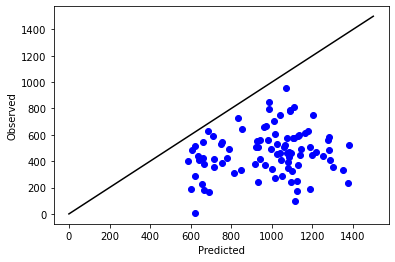

test data correlation coefficient is: 0.6828564682305619


In [13]:
##Running the GA model on VA data

##Really, really needs improvement

va_df1 = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Comparisons/va_df1.csv')

va_xargs = va_df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']]

va_yargs = va_df1['liveMass']

va_pred=pipe.predict(va_xargs)

print('Mean Absolute Error:', metrics.mean_absolute_error(va_yargs, va_pred))
print('Mean Squared Error:', metrics.mean_squared_error(va_yargs, va_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(va_yargs, va_pred)))
r_square = metrics.r2_score(va_yargs, va_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(va_yargs, va_pred))/np.ptp(va_yargs)))


plt.scatter(va_pred, va_yargs, color = 'blue')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 1500], [0, 1500], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

Mean Absolute Error: 308.46658376118245
Mean Squared Error: 254019.18984042402
Root Mean Squared Error: 504.0031645142955
The r squared is: 0.4058333576496387
0.4058333576496387
testing r2 is: 0.4058333576496387
training r2 is: 0.9053156419748772
NRMSE is: 0.10966107206825913
MEAN BASELINE:
Mean Absolute Error: 433.95318317492706
Root Mean Squared Error: 656.8091950621074


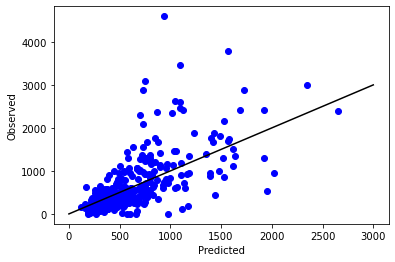

test data correlation coefficient is: 0.6421627635712808
train data correlation coefficient is: 0.9633352071819892


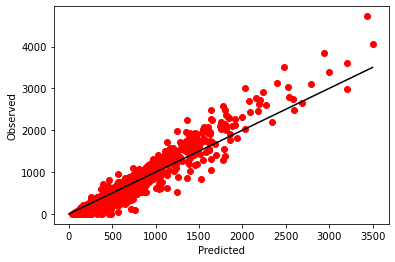

In [19]:
##Combining the datasets

combined_df = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Comparisons/gavacombined.csv')

combined_df = combined_df[combined_df['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
combined_df = combined_df[combined_df['prcp'].notna()] ##CAREFUL; added 7/11/22
combined_df = combined_df[combined_df['Species_Code'] == 'A1'] ##careful here

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xargs=combined_df[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'swe','vp']]

##From linear regression results: maybe remove nd_swir2_nir/r from feature list? May improve prediction results. 
##Also: nd_r_g, dayl, and vp all can be removed. Seasonal average vs. yearly average will probably be a choice.

#'sn_prcp', 'sn_dayl', 'sn_tmax', 'sn_tmin', 'sn_srad', 'sn_vp'

##Include lag variables (e.g. lag ndvi), precip, temp, more

##ELEVATION NEEDS TO BE TRIPLE-CHECKED AT EACH PLOT TO MAKE SURE VALUES CORRESPOND

yargs=combined_df['Plant_Biomass'] 

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

# # Pipeline example:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

plt.scatter(y_pred, yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

train_pred = pipe.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3500], [0, 3500], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))


In [20]:
combined_df

,B1,B2,B3,B4,B5,B6,B7,system:index,Site,Species_Code,...,sn_vp,Latitude,Longitude,dayl,prcp,srad,swe,tmax,tmin,vp
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0,1,A1,...,1776.901489,31.538627,-81.422539,43200.08594,2.568438,342.593597,0.000000,25.048056,14.132274,1776.901489
1,0.0263,0.0404,0.0351,0.0745,0.0697,0.2883,0.0448,0,1,A1,...,1762.035522,31.538627,-81.422539,43220.08203,2.596593,342.510712,0.000000,25.575659,14.795082,1762.035522
3,0.0344,0.0429,0.0374,0.0798,0.0649,0.2951,0.0362,0,1,A1,...,1778.461426,31.538627,-81.422539,43200.08594,3.297945,340.148438,0.000000,25.406548,14.338548,1778.461426
4,0.0240,0.0361,0.0321,0.0872,0.0559,0.2947,0.0309,0,1,A1,...,1799.670776,31.538627,-81.422539,43220.08203,4.259862,338.359924,0.000000,25.079752,14.206429,1799.670776
5,0.0598,0.0626,0.0610,0.1112,0.0979,0.2968,0.0613,0,1,A1,...,1683.812134,31.538627,-81.422539,43220.08203,2.628269,351.314453,0.000000,26.066071,14.187940,1683.812134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3303,0.0532,0.0697,0.0731,0.1887,0.2318,0.2994,0.1283,11,N_Brownsville,A1,...,NaN,37.468043,-75.822928,43225.22656,2.652720,317.546905,0.000000,20.071978,10.639917,1469.800293
3304,0.0461,0.0688,0.0698,0.2359,0.2200,0.2990,0.1088,11,N_Brownsville,A1,...,NaN,37.468043,-75.822928,43225.22656,3.918159,302.312927,0.000000,19.204807,10.557253,1459.927246
3305,0.0583,0.0650,0.0623,0.2119,0.2058,0.2973,0.0990,11,N_Brownsville,A1,...,NaN,37.468043,-75.822928,43225.22656,2.801017,312.438080,0.540165,19.641483,10.664945,1483.516724
3306,0.0377,0.0556,0.0542,0.2257,0.1826,0.2964,0.0737,11,N_Brownsville,A1,...,NaN,37.468043,-75.822928,43225.22656,2.758736,313.937012,0.000000,20.372116,11.170687,1494.422729
